# Big Data Bandits

A Project-Group of the DHBW Karlsruhe participating in a AI-powerd World.

# Code
Der Code ermöglicht eine graphische Darstellung der Zusammenhänge aller Posts (Tweets) mit den Veränderungen im Aktienkurs. Dafür enthält der Code alle notwendigen Abschnitte, um eine sinnstiftende Einordnung der Daten und Parameter in den Kontext der Fragestellung zu ermöglichen. Durch seine hohe Modularität kann er auch für ähnliche Analysen verwendet werden.

0. [Bibliotheken](#0-bibliotheken)
1. [Datensätze](#1-datensätze)
    1. [Datensätze einlesen](#11-datensätze-einlesen)
    2. [Datenverständnis](#12-datenverständnis)
        1. [Datendichte](#121-datendichte)
2. [Hilfsmethoden](#2-hilfsmethoden)
    1. [Intervallselektion](#21-intervallselektion)
    2. [Kursverlauf](#22-kursverlauf)
3. [Hauptschleife](#4-hauptschleife)
4. [Erzeugung](#5-erzeugung)
5. [Darstellung](#6-darstellung)
    1. [Korrelationstabelle](#61-korrelationstabelle)
    2. [Posts](#62-posts)
    3. [Trend](#63-trend)
    4. [Absolut](#64-absolut)
    5. [Durchschnitt](#65-durchschnitt)
    6. [Maximale Performance](#66-maximale_performance)

<a name="0-bibliotheken"></a>
## 0. Bibliotheken ##
Es werden diese Libraries zur Ausführung benötigt.

In [120]:
from IPython.display import display
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns

<a name="1-datensätze"></a>
## 1. Datensätze ##

<a name="11-datensätze_einlesen"></a>
### 1.1. Datensätze einlesen ###
Zu Beginn der Analyse werden die Datensätze in einen Pandas-Dataframe eingelesen. Dabei werden ebenfalls die Daten der "Date" bzw. "Datetime" Spalte korrekt als Python Datetime-Objekt geparst, um eine zukünftige, datumsbasierte Weiterverarbeitung zu erleichtern. Dies geschieht durch den Lambda-Ausdruck: *datetime.strptime(x[0:10], '%Y-%m-%d')* der auf die entsprechende Spalte angewandt wird. Dabei enthält jeder String der entsprechenden Spalte bis zum 10. Charakter das Datum formatiert in Jahr-Monat-Tag. Uhrzeiten und andere folgenden Zeitreferenzen werden einfach abgeschnitten, da auch die Stockdatensätze nur tagesbezogene Daten beinhalten.

In [121]:
dateparse = lambda x: datetime.strptime(x[:10], '%Y-%m-%d')

#Read the CSV files and put them into pandas DataFrame objects
Posts:pd.DataFrame = pd.read_csv('./datasets/elonmusk.csv', parse_dates=['datetime'], date_parser=dateparse).rename(columns={'datetime': 'date'})
Dogecoin:pd.DataFrame = pd.read_csv('./datasets/dogecoin.csv', parse_dates=['date'], date_parser=dateparse)
Tesla:pd.DataFrame = pd.read_csv('./datasets/tesla.csv', parse_dates=['date'], date_parser=dateparse)

display(Posts.head())
display(Tesla.head())
display(Dogecoin.head())

C:\Users\ZODWEISS\AppData\Local\Temp\ipykernel_18684\3951701588.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  Posts:pd.DataFrame = pd.read_csv('./datasets/elonmusk.csv', parse_dates=['datetime'], date_parser=dateparse).rename(columns={'datetime': 'date'})
C:\Users\ZODWEISS\AppData\Local\Temp\ipykernel_18684\3951701588.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  Dogecoin:pd.DataFrame = pd.read_csv('./datasets/dogecoin.csv', parse_dates=['date'], date_parser=dateparse)
C:\Users\ZODWEISS\AppData\Local\Temp\ipykernel_18684\3951701588.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or 

,date,tweet id,text,username
0,2023-06-29,1674452749378002945,@mwseibel Yup,elonmusk
1,2023-06-29,1674446089179766789,@TitterDaily True,elonmusk
2,2023-06-29,1674263071337111552,@paulg Generational trauma. An example of why ...,elonmusk
3,2023-06-29,1674226170488057856,Improved longform posts,elonmusk
4,2023-06-28,1674116945808068608,@BillyM2k Best protip ever,elonmusk


,date,open,high,low,close,volume,raw_close,change_percent,avg_vol_20d
0,2010-06-29,1.26666,1.66666,1.16934,1.59266,281749173,23.8899,NaN,NaN
1,2010-06-30,1.71934,2.02794,1.55334,1.58866,257915884,23.8299,-0.25,NaN
2,2010-07-01,1.66666,1.72800,1.35134,1.46400,123447940,21.9600,-7.85,NaN
3,2010-07-02,1.53334,1.54000,1.24734,1.28000,77127102,19.2000,-12.57,NaN
4,2010-07-06,1.33334,1.33334,1.05534,1.07400,103189435,16.1100,-16.09,NaN


,date,open,high,low,raw_close,close,volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270


<a name="12-datenverständnis"></a>
### 1.2. Datenverständnis ###

<a name="121-datendichte"></a>
#### 1.2.1. Datendichte ###
Der nun folgende Abschnitt erstellt eine grafische Übersicht, welche die fehlenden Tage aus den Datensätzen entsprechend dem Datum aufträgt.
Dafür erstellt die Methode *get_density* einen neuen Datensatz mit der Auswertung. 
Dieser neue Datensatz enthält nun in der Spalte "date" alle Daten, die bei Vollständigkeit in dem zu untersuchenden Datensatz enthalten sein müssten.
Die Spalte "exists" enthält nun für jedes Datum den entsprechenden Boolean- bzw. Integer-Wert 1 oder 0.
Dabei bedeutet eine 1, dass der Tag im untersuchten Datensatz existiert, während eine 0 für einen fehlenden Tag im untersuchten Datensatz steht.

In [122]:
def get_density(df:pd.DataFrame):
    start_date = min(df["date"]).replace(hour=0, minute=0, second=0, microsecond=0)
    end_date = max(df["date"]).replace(hour=0, minute=0, second=0, microsecond=0) + pd.Timedelta(days=1)

    all_dates = pd.DataFrame({'date': pd.date_range(start_date, end_date, freq='D')})
    all_dates['exists'] = all_dates['date'].isin(df["date"]).astype(int)

    return all_dates

Im Folgenden wird für alle 3 Datensätze diese Auswertung erstellt.

In [123]:
Posts_density = get_density(Posts)
Tesla_density = get_density(Tesla)
Dogecoin_density = get_density(Dogecoin)

Daraufhin können diese neuen Datensätze unter Verwendung von PyPlot graphisch dargestellt werden.
Dabei ist insbesondere die Größe des Plots relevant, da sonst die wenigen fehlenden Werte in der Gesamtmasse untergehen würden.
So werden jeweils zunächst die existenten Tage in Blau aufgetragen, anschließend werden die fehlenden Tage in Rot ergänzt.

Text(2017-11-09 00:00:00, 4.5, 'Dogecoin')

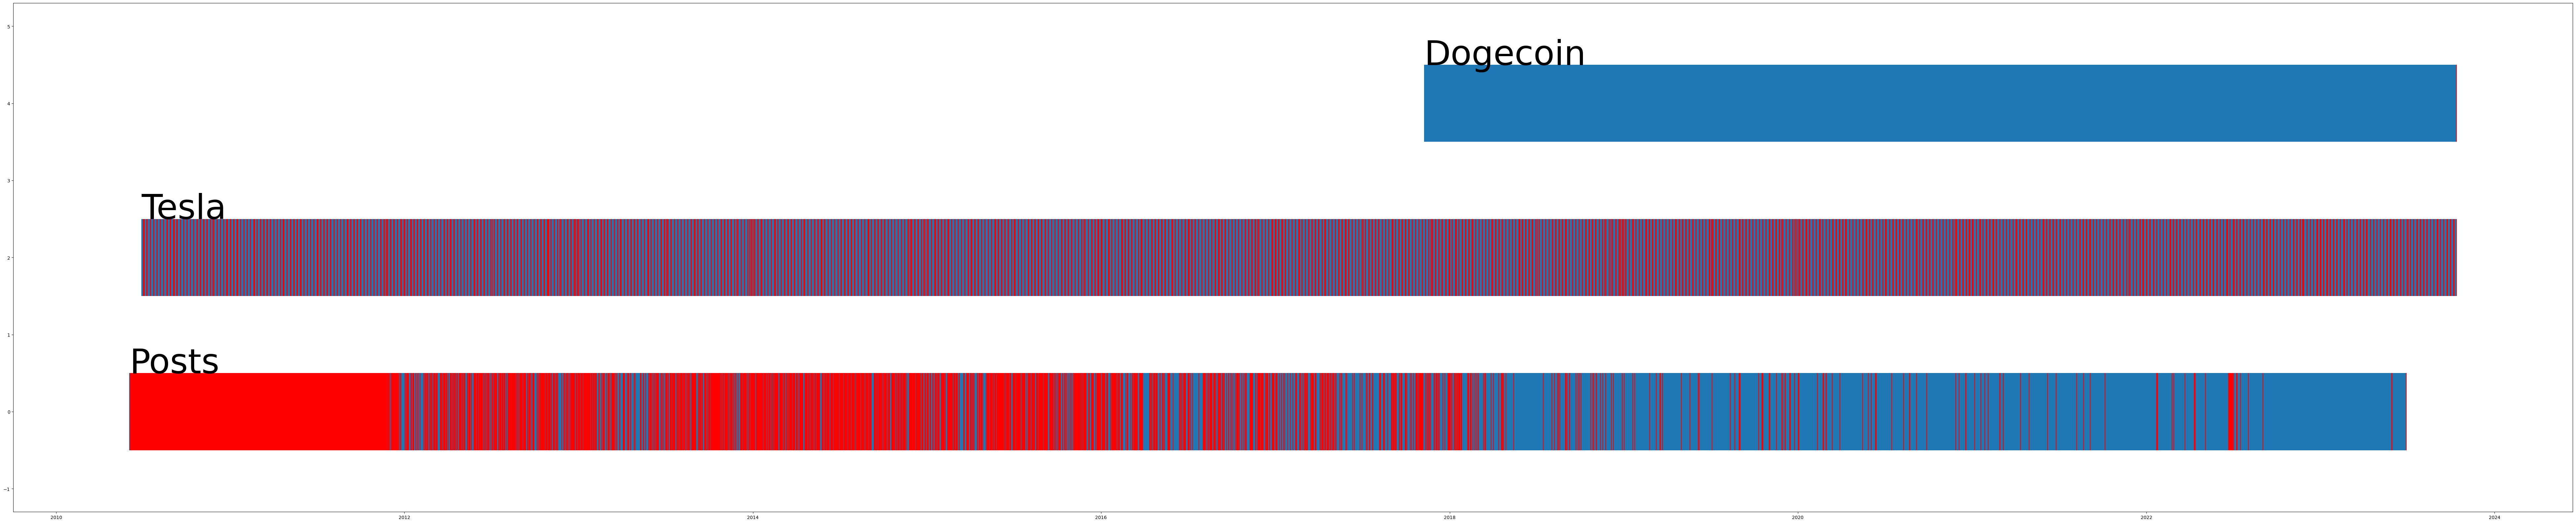

In [124]:
plt.figure(figsize=(100,20))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.eventplot(Posts_density.loc[Posts_density['exists'] == 1, 'date'], lineoffsets=0, label = "Posts")
plt.eventplot(Posts_density.loc[Posts_density['exists'] == 0, 'date'], lineoffsets=0, colors=['red'])

plt.eventplot(Tesla_density.loc[Tesla_density['exists'] == 1, 'date'], lineoffsets=2, label = "Tesla")
plt.eventplot(Tesla_density.loc[Tesla_density['exists'] == 0, 'date'], lineoffsets=2, colors=['red'])

plt.eventplot(Dogecoin_density.loc[Dogecoin_density['exists'] == 1, 'date'], lineoffsets=4, label = "Dogecoin")
plt.eventplot(Dogecoin_density.loc[Dogecoin_density['exists'] == 0, 'date'], lineoffsets=4, colors=['red'])

plt.text(Posts_density.loc[Posts_density['exists'] == 1, 'date'].iloc[0], 0.5, 'Posts', color='black', fontsize=75)
plt.text(Tesla_density.loc[Tesla_density['exists'] == 1, 'date'].iloc[0], 2.5, 'Tesla', color='black', fontsize=75)
plt.text(Dogecoin_density.loc[Dogecoin_density['exists'] == 1, 'date'].iloc[0], 4.5, 'Dogecoin', color='black', fontsize=75)

Zu guter Letzt lassen wir uns noch den fehlenden Anteil der Daten im Verhältnis zum gesamten Datensatz in Prozent ausgeben.

<BarContainer object of 3 artists>

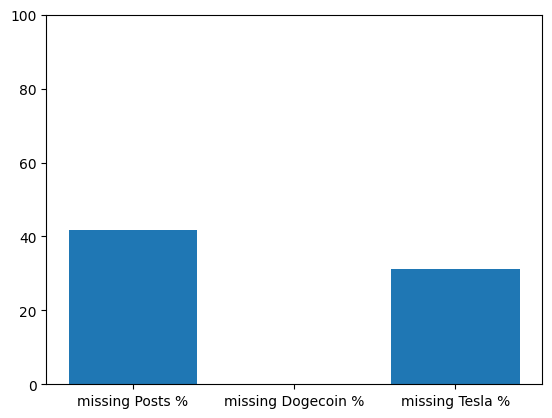

In [125]:
plt.ylim(0, 100)

plt.bar(
    ["missing Posts %", "missing Dogecoin %", "missing Tesla %"], 
    [
        (Posts_density['exists'].value_counts(normalize=True) * 100).get(0, 0),
        (Dogecoin_density['exists'].value_counts(normalize=True) * 100).get(0, 0),
        (Tesla_density['exists'].value_counts(normalize=True) * 100).get(0, 0)
     
    ]
)

<a name="2-hilfsmethoden"></a>
## 2. Hilfsmethoden ##
Im Weiteren definieren wir ein paar Hilfsfunktionen, die uns kleinere Nebenberechnungen im Verlauf der Analyse abnehmen. Dies reduziert insbesondere die Größe der Hauptschleife und erhöht die Übersichtlichkeit des Codes.

<a name="21-intervallselektion"></a>
### 2.1. Intervallselektion ###
Die Methode *check_filter()* erkennt, ob in einem Text gewisse Schlüsselwörter aus einer Filter-Liste enthalten sind. Dies ermöglicht das Filtern der Posts anhand der evtl. im Post (Tweet) enthaltenen Schlüsselwörter (bspw.: "Dogecoin"). Dabei kann in Abhängigkeit der Variable *hit*, entweder nach dem Vorhandensein (hit=True) oder dem Fehlen (hit=Flase) der Schlüsselwörter sortiert werden.

Die Methode *get_interval* generiert einen Datensatz-Ausschnitt, der ausgehend von einem Startdatum die nächsten vorhandenen n Tage aus einem Stock-Datensatz enthält. Die Anzahl der Tage wird durch den Parameter *interval_length* gegeben und beträgt standardmäßig den Wert 3. Es wird außerdem berücksichtigt, dass das Startdatum nicht im Stock-Datensatz enthalten ist. In diesem Fall nimmt das Unterprogramm das nächste vorhandene Datum. Ausgehend von dem gefundenen Datum, werden der Start-Index sowie der End-Index des Datensatz-Ausschnittes berechnet. Dabei wird berücksichtigt, dass das End-Datum ggf. nicht mehr im Datensatz erhalten ist. Trifft dies zu, so kann kein Intervall erstellt werden und es wird None zurückgegeben. (Dieser Fall ist jedoch bei unseren Datensätzen nicht zwingend zu berücksichtigen, da die Stock-Datensätze deutlich aktueller sind, als der Datensatz der Posts (Tweets), aus dem das Startdatum stammt.)

In [126]:
def check_filter(text:str, filter_list:list, hit:bool):
    for filter in filter_list:
        if filter in text:
            return hit
    return not hit

def get_interval(search_date:datetime, stock:pd.DataFrame, interval_length:int=3):
    search_date = search_date - datetime.timedelta(days=1)

    #find the start date under the consideration that the given startdate does not exist
    next_available_startdate = stock.loc[stock['date'] >= search_date, 'date'].min()

    start_index = stock[stock['date'] == next_available_startdate].index[0]
    end_index = start_index + interval_length

    if end_index > stock.index[-1]:
        return None
    else:
        return stock.iloc[start_index:end_index]

<a name="22-kursverlauf"></a>
### 2.2. Kursverlauf ###
Die nun folgenden Hilfsmethoden werden dazu verwendet, die Änderung des Aktienkurses im gegeben Zeitraum zu ermöglichen.
Dafür betrachten wir die Spalte "close", die dem täglichen Abschlusswert der Aktie entspricht

So berechnet die Methode *get_absolute()* den prozentualen Unterschied zwischen dem ersten sowie letzten Tag des Intervalls.
Dies erfolgt durch die Formel (d_0 - d_n) / |d_n| * 100, dabei entspricht d_0 dem ersten Tag und d_n dem letzten Tag des Intervalls:

Die nachfolgende Methode **get_trend()** ist ein wichtiges Kernstück der Analyse.
Diese Funktion ermittelt mithilfe einer linearen Regression eine Gerade, welche das Wachstum einer Aktie für einen gegebenen Zeitraum repräsentiert.
Anschließend wird mithilfe des Modells der erwartete Wert der Aktie für den ersten bzw. letzten Tag des zu betrachtenden Intervalls berechnet.
Mit diesen beiden abgeleiteten Werten kann, wie in der Methode *get_absolute()* beschrieben, der prozentuale Unterschied kalkuliert werden.
Dieses Verfahren hat den Vorteil, dass alle Werte des Intervalls gleichermaßen berücksichtigt werden.

In [127]:
def get_absolute(stock_part:pd.DataFrame):
    initial = stock_part.iloc[0]["close"]
    final = stock_part.iloc[-1]["close"]
    return round((final - initial) / abs(initial) * 100, 4) * 100

def get_trend(stock_part:pd.DataFrame):
    colses_of_interval:list = stock_part["close"].tolist()
    
    x = np.array(range(len(colses_of_interval))).reshape(-1, 1)
    y = np.array(colses_of_interval)

    model = LinearRegression().fit(x, y)

    x_first = np.array([0]).reshape(-1, 1)
    x_last = np.array([len(colses_of_interval) - 1]).reshape(-1, 1)

    y_first = model.predict(x_first)[0]
    y_last = model.predict(x_last)[0]

    change_percentage = round((y_last - y_first) / abs(y_first), 4) * 100

    return [change_percentage, model]

<a name="3-hauptschleife"></a>
## 3. Hauptschleife ##
Die Hauptschleife umfasst die grundlegende Funktionalität zur Auswertung der Datensätze in Bezug auf die Fragestellung.
Aufgrund der hohen Komplexität des Vorgangs konnte nicht auf eine Funktionskombination bestehender APIs zurückgegriffen werden. Somit musste die Funktion von Grund auf neu entwickelt werden.
Dafür wird ein neuer Datensatz *influence* erstellt, welcher alle Tage, an denen ein Post mit den entsprechenden Filterkriterien verfasst wurde, umfasst.
Für jeden dieser Tage wird das Datum, eine Liste aller Posts, die Anzahl dieser Posts, sowie die errechneten Kursverläufe aufgezeichnet.
So iteriert diese Schleife zunächst über alle Posts (Tweets), die im Datensatz Posts enthalten sind.
Im Anschluss wird nun durch die Methode *check_filter* überprüft, ob die aktuelle Zeile den Filteransprüchen gerecht wird.
Trifft dies nicht zu, so wird diese Zeile übersprungen.
Ansonsten wird das Datum aus der aktuellen Zeile ausgelesen.
Im Folgenden wird überprüft, ob der aktuelle Tag schon im Datensatz "influence" enthalten ist, was zutrifft, wenn an einem Tag mehrere Posts vorliegen. Ist dies der Fall, so wird dieser nur um den aktuellen Posttext ergänzt, sowie die Anzahl der Posts an diesem Tag inkrementiert.
Ist dieser Tag noch nicht im Datensatz "influences" enthalten, so wird für den aktuellen Tag zunächst das Intervall des Stock-Datensatzes bestimmt.
Ist dies nicht möglich, weil ggf. Daten fehlen, wird eine Warnung ausgegeben und die Schleife fährt fort.
(Dies ist jedoch wie in 2.1 beschrieben zu vernachlässigen).
Wenn das Intervall erfolgreich erstellt wurde, werden nun alle Berechnungen der beiden Hilfsfunktionen auf dieses angewandt.
Schlussendlich werden alle Werte unter diesem Tag in den Datensatz "influences" eingefügt.
Hat die Schleife alle Posts abgearbeitet, kann dieser Datensatz zurückgegeben werden.
Zudem wird der prozentuale Anteil der im "influence" enthaltenen Posts von allen Posts ermittelt und zurückgegeben.

In [128]:
def get_influence(stock:pd.DataFrame, posts:pd.DataFrame=Posts, filter_list:list=[], hit:bool=False, interval_length:int=3):
    # find a common start date
    start_date = max(posts['date'].min(), stock['date'].min())
    # adjust Posts to startdate
    posts = posts[posts['date'] >= start_date]
    # adjust Stock to startdate
    stock = stock[stock['date'] >= start_date]

    influence:pd.DataFrame = pd.DataFrame(columns=['date', 'posts', 'count_posts', 'trend', 'absolute'])
    j = 0
    old_date = None
    
    for i, post in posts.iterrows():
        if not check_filter(str(post['text']), filter_list, hit=hit):
            continue
        else:
            date = pd.to_datetime(post['date']).normalize()
            
            if not date == old_date:
                interval = get_interval(date, stock, interval_length)

                if interval is None:
                    print("No Data Available")
                    continue

                cp_trend, model = get_trend(interval)
                cp_absolute = get_absolute(interval)
                influence.loc[j] = [date] + [[post['text']]] + [0] + [cp_trend] + [cp_absolute]
                old_date = date
                j += 1

            else:
                influence.loc[j-1, 'posts'].append(post['text'])
                influence.loc[j-1, 'count_posts'] += 1
    return [influence, j/i*100]


<a name="4-erzeugung"></a>
## 4. Erzeugung ##
Im Folgenden können nun beliebig viele Datensätze zur Analyse erstellt werden.
Dafür wird eine Filter-Liste mit den entsprechenden Schlüsselwörtern der Funktion *get_influence* übergeben.
Außerdem kann optional das zu betrachtende Zeitintervall beliebig angepasst werden.

In [129]:
import datetime

filter_doge = ["doge", "Doge", "DOGE"]
filter_tsla = ["tesla", "Tesla", "TESLA", "TSLA", "tsla"]

#without filtration
influences_DOGE_total_i3, part_DOGE_total = get_influence(Dogecoin, Posts, [], False, interval_length=3)
influences_DOGE_total_i5, part_DOGE_total = get_influence(Dogecoin, Posts, [], False, interval_length=5)
influences_TSLA_total_i3, part_TSLA_total = get_influence(Tesla, Posts, [], False, interval_length=3)
influences_TSLA_total_i5, part_TSLA_total = get_influence(Tesla, Posts, [], False, interval_length=5)

#with filtration ([i]ncluded / [e]xcluded)
influences_DOGE_i_i3, part_DOGE_i = get_influence(Dogecoin, Posts, filter_doge, True, interval_length=3)
influences_DOGE_i_i5, part_DOGE_i = get_influence(Dogecoin, Posts, filter_doge, True, interval_length=5)
influences_DOGE_e_i3, part_DOGE_e = get_influence(Dogecoin, Posts, filter_doge, False, interval_length=3)
influences_DOGE_e_i5, part_DOGE_e = get_influence(Dogecoin, Posts, filter_doge, False, interval_length=5)

influences_TSLA_i_i3, part_TSLA_i = get_influence(Tesla, Posts, filter_tsla, True, interval_length=3)
influences_TSLA_i_i5, part_TSLA_i = get_influence(Tesla, Posts, filter_tsla, True, interval_length=5)
influences_TSLA_e_i3, part_TSLA_e = get_influence(Tesla, Posts, filter_tsla, False, interval_length=3)
influences_TSLA_e_i5, part_DOGE_e = get_influence(Tesla, Posts, filter_tsla, False, interval_length=5)

#combined with filtration ([i]ncluded / [e]xcluded)
influences_COMB_i_i3, part_COMB_i = get_influence(Dogecoin, Posts, filter_doge + filter_tsla, True, interval_length=3)
influences_COMB_i_i5, part_COMB_i = get_influence(Dogecoin, Posts, filter_doge + filter_tsla, True, interval_length=5)
influences_COMB_e_i3, part_COMB_e = get_influence(Dogecoin, Posts, filter_doge + filter_tsla, False, interval_length=3)
influences_COMB_e_i5, part_COMB_e = get_influence(Dogecoin, Posts, filter_doge + filter_tsla, False, interval_length=5)

<a name="5-darstellung"></a>
## 5. Darstellung ##

<a name="51-Korrelationstabelle"></a>
### 5.1. Korrelationstabelle ###

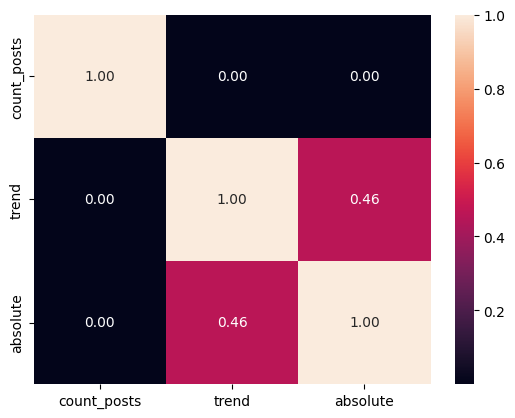

In [139]:
influences_corr = pd.concat(
    [
        influences_DOGE_total_i3[['count_posts', 'trend', 'absolute']],
        influences_TSLA_total_i3[['count_posts', 'trend', 'absolute']],
        influences_DOGE_total_i5[['count_posts', 'trend', 'absolute']],
        influences_TSLA_total_i5[['count_posts', 'trend', 'absolute']]
    ]
).corr()


sns.heatmap(influences_corr, annot=True, fmt=".2f")
plt.show()

<a name="52-posts"></a>
### 5.2. Posts ###

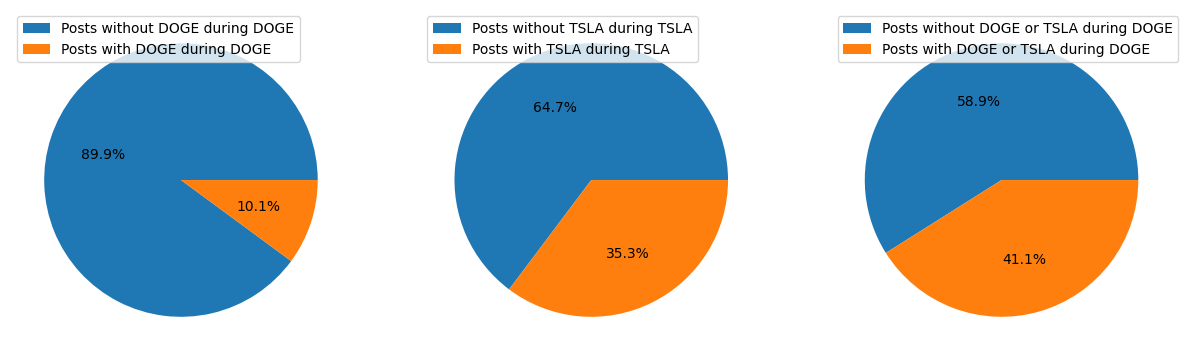

In [131]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Erstes Pie-Chart (DOGE)
axs[0].pie([part_DOGE_e, part_DOGE_i], autopct='%1.1f%%')
axs[0].legend(labels=["Posts without DOGE during DOGE", "Posts with DOGE during DOGE"], loc="upper left")

# Zweites Pie-Chart (TSLA)
axs[1].pie([part_TSLA_e, part_TSLA_i], autopct='%1.1f%%')
axs[1].legend(labels=["Posts without TSLA during TSLA", "Posts with TSLA during TSLA"], loc="upper left")

# Drittes Pie-Chart (DOGE und TSLA)
axs[2].pie([part_COMB_e, part_COMB_i], autopct='%1.1f%%')
axs[2].legend(labels=["Posts without DOGE or TSLA during DOGE", "Posts with DOGE or TSLA during DOGE"], loc="upper left")
plt.show()

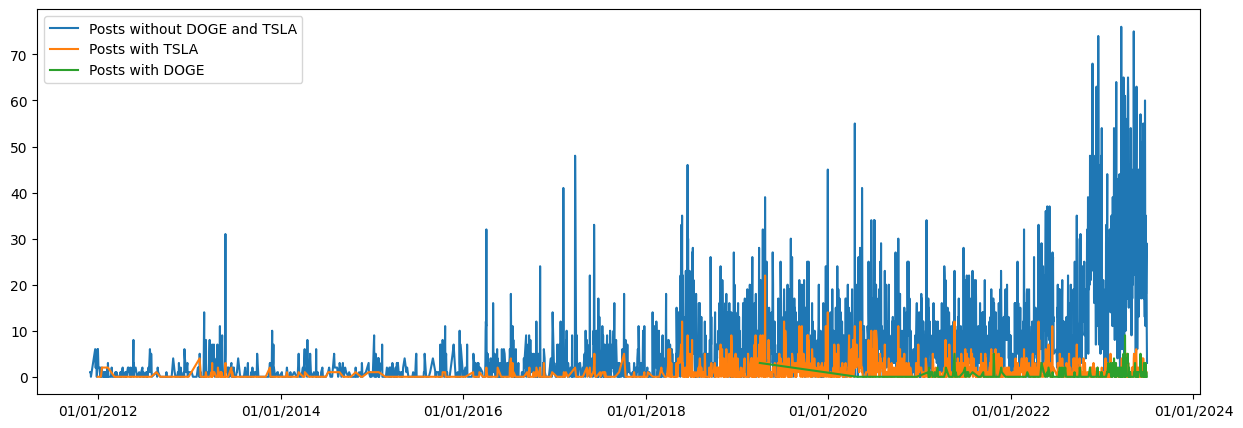

In [132]:
plt.figure(figsize=(15, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))

plt.plot(influences_TSLA_total_i3['date'], influences_TSLA_total_i3['count_posts'])
plt.plot(influences_TSLA_i_i3['date'], influences_TSLA_i_i3['count_posts'])
plt.plot(influences_DOGE_i_i3['date'], influences_DOGE_i_i3['count_posts'])
plt.legend(labels=["Posts without DOGE and TSLA", "Posts with TSLA", "Posts with DOGE"], loc="upper left")

<a name="53-trend"></a>
### 5.3. Trend ###

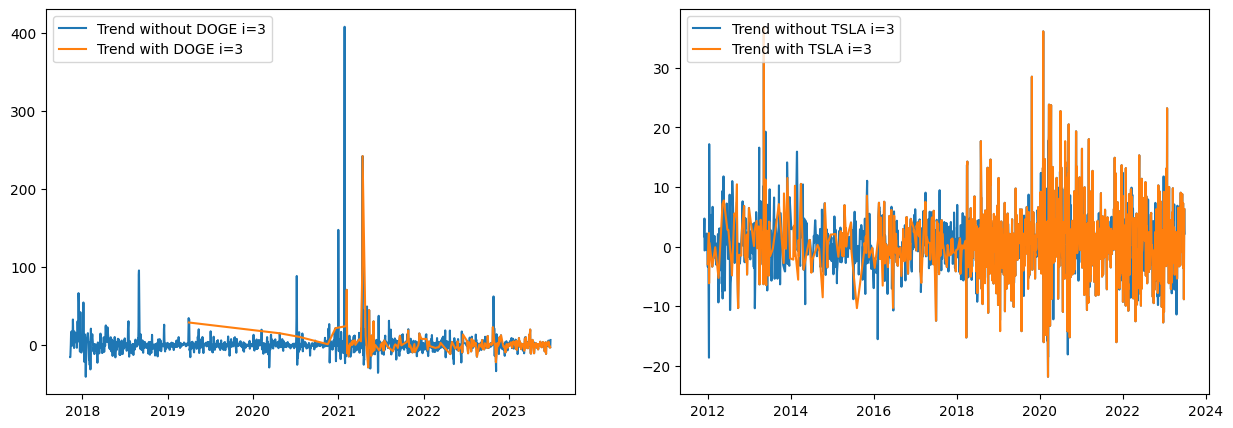

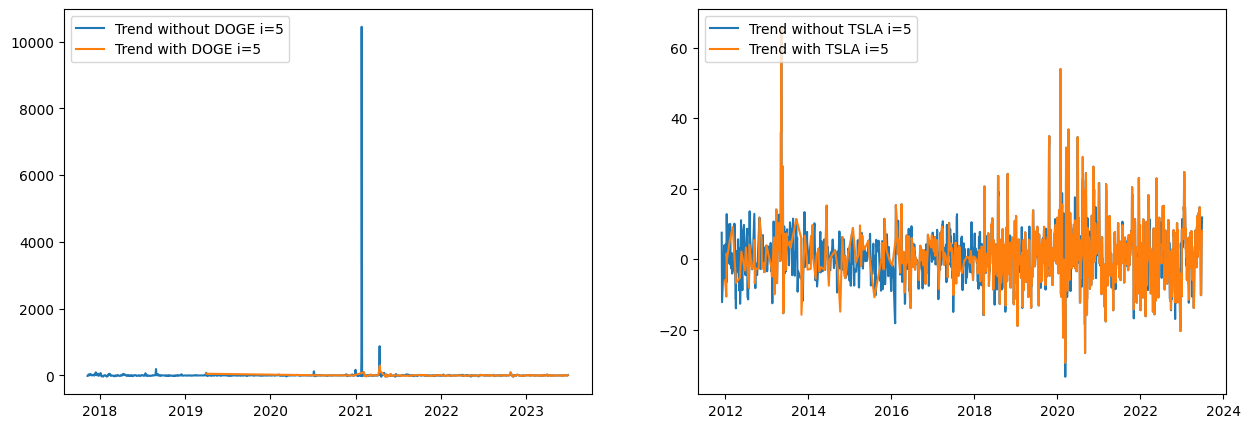

In [133]:
fig1, axs1 = plt.subplots(1, 2, figsize=(15, 5))
fig2, axs2 = plt.subplots(1, 2, figsize=(15, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axs1[0].plot(influences_DOGE_e_i3['date'], influences_DOGE_e_i3['trend'])
axs1[0].plot(influences_DOGE_i_i3['date'], influences_DOGE_i_i3['trend'])
axs1[0].legend(labels=["Trend without DOGE i=3", "Trend with DOGE i=3"], loc="upper left")
axs1[1].plot(influences_TSLA_e_i3['date'], influences_TSLA_e_i3['trend'])
axs1[1].plot(influences_TSLA_i_i3['date'], influences_TSLA_i_i3['trend'])
axs1[1].legend(labels=["Trend without TSLA i=3", "Trend with TSLA i=3"], loc="upper left")

axs2[0].plot(influences_DOGE_e_i5['date'], influences_DOGE_e_i5['trend'])
axs2[0].plot(influences_DOGE_i_i5['date'], influences_DOGE_i_i5['trend'])
axs2[0].legend(labels=["Trend without DOGE i=5", "Trend with DOGE i=5"], loc="upper left")
axs2[1].plot(influences_TSLA_e_i5['date'], influences_TSLA_e_i5['trend'])
axs2[1].plot(influences_TSLA_i_i5['date'], influences_TSLA_i_i5['trend'])
axs2[1].legend(labels=["Trend without TSLA i=5", "Trend with TSLA i=5"], loc="upper left")

<a name="54-absolut"></a>
### 5.4. Absolut ###

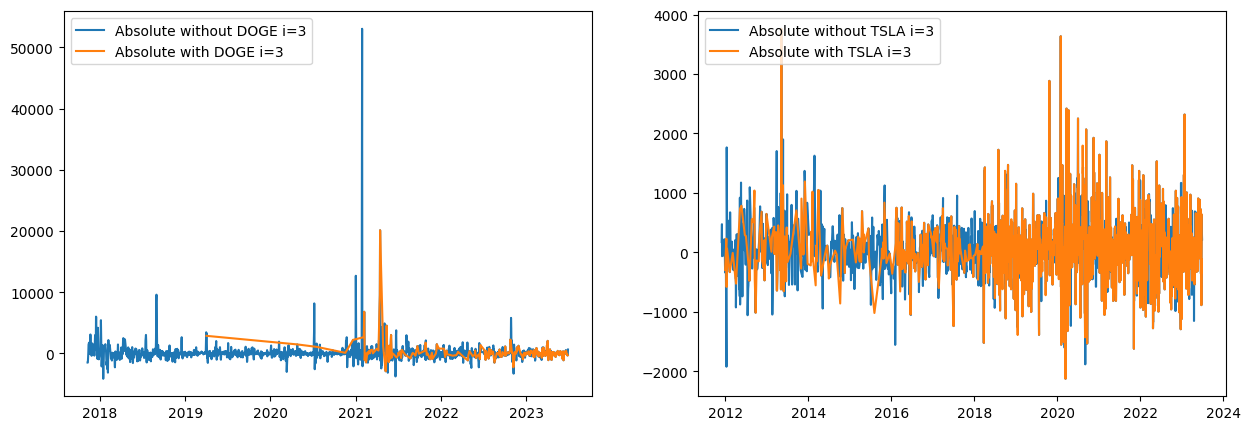

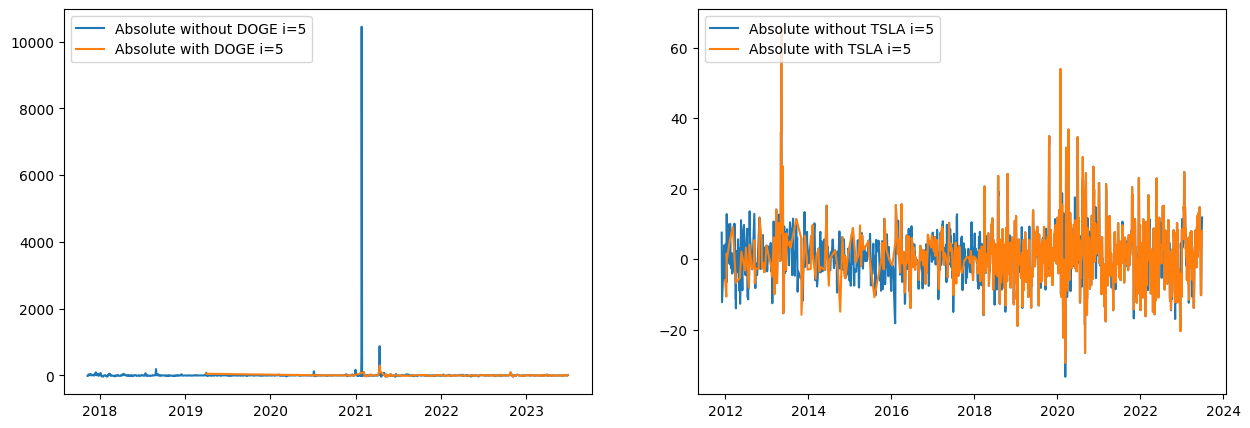

In [134]:
fig1, axs1 = plt.subplots(1, 2, figsize=(15, 5))
fig2, axs2 = plt.subplots(1, 2, figsize=(15, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axs1[0].plot(influences_DOGE_e_i3['date'], influences_DOGE_e_i3['absolute'])
axs1[0].plot(influences_DOGE_i_i3['date'], influences_DOGE_i_i3['absolute'])
axs1[0].legend(labels=["Absolute without DOGE i=3", "Absolute with DOGE i=3"], loc="upper left")
axs1[1].plot(influences_TSLA_e_i3['date'], influences_TSLA_e_i3['absolute'])
axs1[1].plot(influences_TSLA_i_i3['date'], influences_TSLA_i_i3['absolute'])
axs1[1].legend(labels=["Absolute without TSLA i=3", "Absolute with TSLA i=3"], loc="upper left")

axs2[0].plot(influences_DOGE_e_i5['date'], influences_DOGE_e_i5['trend'])
axs2[0].plot(influences_DOGE_i_i5['date'], influences_DOGE_i_i5['trend'])
axs2[0].legend(labels=["Absolute without DOGE i=5", "Absolute with DOGE i=5"], loc="upper left")
axs2[1].plot(influences_TSLA_e_i5['date'], influences_TSLA_e_i5['trend'])
axs2[1].plot(influences_TSLA_i_i5['date'], influences_TSLA_i_i5['trend'])
axs2[1].legend(labels=["Absolute without TSLA i=5", "Absolute with TSLA i=5"], loc="upper left")

<a name="55-darstellung"></a>
### 5.5. Durchschnitt ###

<BarContainer object of 4 artists>

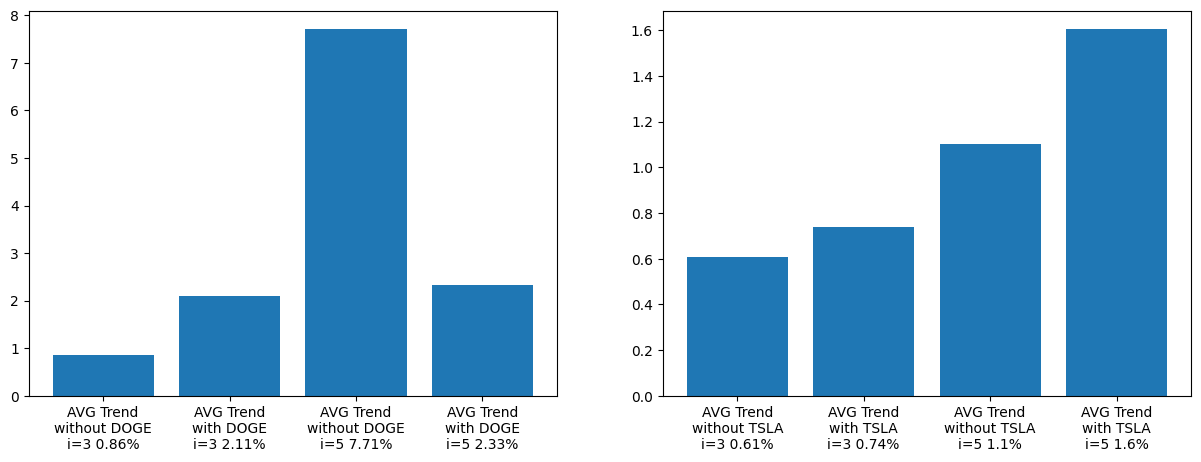

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

influences_DOGE_trend_avg = [
    influences_DOGE_e_i3['trend'].mean(),
    influences_DOGE_i_i3['trend'].mean(),
    influences_DOGE_e_i5['trend'].mean(),
    influences_DOGE_i_i5['trend'].mean()
]
influences_DOGE_trend_lbl = [
    f"AVG Trend\nwithout DOGE\ni=3 {round(influences_DOGE_trend_avg[0], 2)}%",
    f"AVG Trend\nwith DOGE\ni=3 {round(influences_DOGE_trend_avg[1], 2)}%",
    f"AVG Trend\nwithout DOGE\ni=5 {round(influences_DOGE_trend_avg[2], 2)}%",
    f"AVG Trend\nwith DOGE\ni=5 {round(influences_DOGE_trend_avg[3], 2)}%"
]

influences_TSLA_trend_avg = [
    influences_TSLA_e_i3['trend'].mean(),
    influences_TSLA_i_i3['trend'].mean(),
    influences_TSLA_e_i5['trend'].mean(),
    influences_TSLA_i_i5['trend'].mean()
]
influences_TSLA_trend_lbl = [
    f"AVG Trend\nwithout TSLA\ni=3 {round(influences_TSLA_trend_avg[0], 2)}%",
    f"AVG Trend\nwith TSLA\ni=3 {round(influences_TSLA_trend_avg[1], 2)}%",
    f"AVG Trend\nwithout TSLA\ni=5 {round(influences_TSLA_trend_avg[2], 2)}%",
    f"AVG Trend\nwith TSLA\ni=5 {round(influences_TSLA_trend_avg[3], 2)}%"
]

axs[0].bar(influences_DOGE_trend_lbl, influences_DOGE_trend_avg)
axs[1].bar(influences_TSLA_trend_lbl, influences_TSLA_trend_avg)

<BarContainer object of 4 artists>

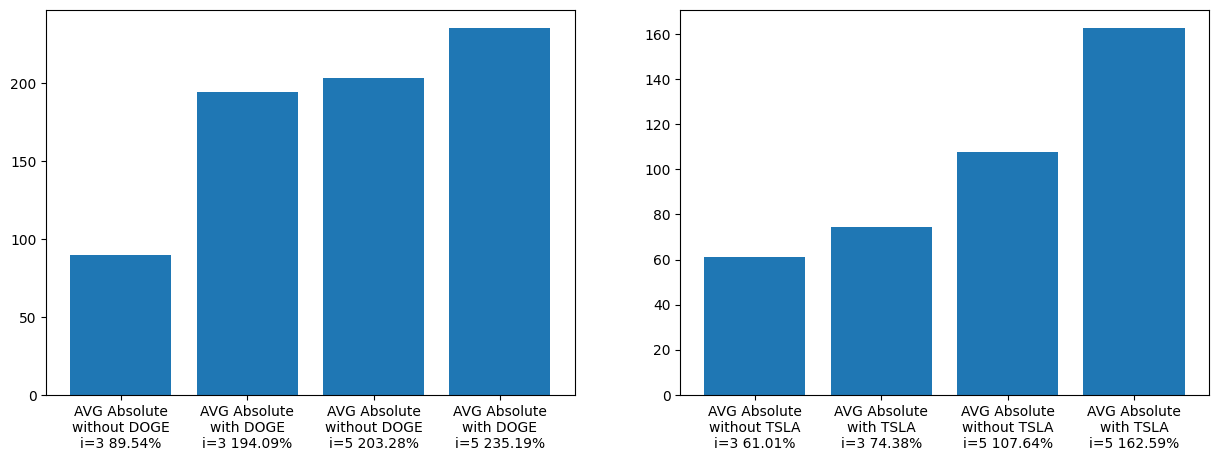

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

influences_DOGE_absolute_avg = [
    influences_DOGE_e_i3['absolute'].mean(),
    influences_DOGE_i_i3['absolute'].mean(),
    influences_DOGE_e_i5['absolute'].mean(),
    influences_DOGE_i_i5['absolute'].mean()
]
influences_DOGE_absolute_lbl = [
    f"AVG Absolute\nwithout DOGE\ni=3 {round(influences_DOGE_absolute_avg[0], 2)}%",
    f"AVG Absolute\nwith DOGE\ni=3 {round(influences_DOGE_absolute_avg[1], 2)}%",
    f"AVG Absolute\nwithout DOGE\ni=5 {round(influences_DOGE_absolute_avg[2], 2)}%",
    f"AVG Absolute\nwith DOGE\ni=5 {round(influences_DOGE_absolute_avg[3], 2)}%"
]

influences_TSLA_absolute_avg = [
    influences_TSLA_e_i3['absolute'].mean(),
    influences_TSLA_i_i3['absolute'].mean(),
    influences_TSLA_e_i5['absolute'].mean(),
    influences_TSLA_i_i5['absolute'].mean()
]
influences_TSLA_absolute_lbl = [
    f"AVG Absolute\nwithout TSLA\ni=3 {round(influences_TSLA_absolute_avg[0], 2)}%",
    f"AVG Absolute\nwith TSLA\ni=3 {round(influences_TSLA_absolute_avg[1], 2)}%",
    f"AVG Absolute\nwithout TSLA\ni=5 {round(influences_TSLA_absolute_avg[2], 2)}%",
    f"AVG Absolute\nwith TSLA\ni=5 {round(influences_TSLA_absolute_avg[3], 2)}%"
]

axs[0].bar(influences_DOGE_absolute_lbl, influences_DOGE_absolute_avg)
axs[1].bar(influences_TSLA_absolute_lbl, influences_TSLA_absolute_avg)

<a name="56-maximale_perfomance"></a>
### 5.6. Maximale Perfomance ###

In [153]:
max_trend_DOGE_i = pd.concat([influences_DOGE_i_i3.loc[influences_DOGE_i_i3["trend"].idxmax()], influences_DOGE_i_i5.loc[influences_DOGE_i_i5["trend"].idxmax()]])
max_absolute_DOGE_i = pd.concat([influences_DOGE_i_i3.loc[influences_DOGE_i_i3["absolute"].idxmax()], influences_DOGE_i_i5.loc[influences_DOGE_i_i5["absolute"].idxmax()]])

max_trend_TSLA_i = pd.concat([influences_TSLA_i_i3.loc[influences_TSLA_i_i3["trend"].idxmax()], influences_TSLA_i_i5.loc[influences_TSLA_i_i5["trend"].idxmax()]])
max_absolute_TSLA_i = pd.concat([influences_TSLA_i_i3.loc[influences_TSLA_i_i3["absolute"].idxmax()], influences_TSLA_i_i5.loc[influences_TSLA_i_i5["absolute"].idxmax()]])

print("-----MAX DOGE-----")
print(max_trend_DOGE_i["date"], list(max_trend_DOGE_i["posts"]))
#print(max_absolute_DOGE_i["date"], list(max_absolute_DOGE_i["posts"]))

print("\n-----MAX TSLA-----")
print(max_trend_TSLA_i["date"], list(max_trend_TSLA_i["posts"]))
#print(max_absolute_TSLA_i["date"], list(max_absolute_TSLA_i["posts"]))

-----MAX DOGE-----
date    2021-04-15 00:00:00
date    2021-04-14 00:00:00
dtype: object [['@sadiaslayy @DogecoinBets 😮', 'Doge Barking at the Moon https://t.co/QFB81D7zOL', '@WSBChairman Doge Barking at the Moon – Miro https://t.co/1vTM2XOusy'], ['@AstroJordy @dogeofficialceo @F9Block5 Insanely cute!', '@dogeofficialceo @F9Block5 🤣🤣']]

-----MAX TSLA-----
date    2013-05-09 00:00:00
date    2013-05-08 00:00:00
dtype: object [['There is a way for the Tesla Model S to be recharged throughout the country faster than you could fill a gas tank.', '@HowardReiter Totally agree. Tesla will circle back and do something cool for Roadsters next year.'], ["Just want to say thanks to customers &amp; investors that took a chance on Tesla through the long, dark night. We wouldn't be here without you."]]
